# How Convolution layer works?


- 기수: 13기

- 이름: 송채은

- 작성자: 13기 강승우

압축을 해제한 폴더 그대로 경로 변경 없이 문제를 푸시면됩니다.  
**CNN assignment폴더 아래에 data폴더, CNN 노트북파일, 이미지파일이 위치해야합니다.**  
문제가 생길 경우 경로 코드를 수정하시거나, 학술부에게 문의해주세요

이번 문제에서는 직접 Convolution 연산을 구현해보며 CNN의 동작 원리를 알아보고자 합니다.

**목표**
- `nn.Conv2d`와 동일한 연산을 **NumPy로 직접 구현**
- laplacian filter와 sobel filter를 **이미지에 적용**

**라이브러리 및 함수 정의**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Optional

# 시각화 유틸
def show_gray(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def minmax_norm(x: np.ndarray, eps: float = 1e-12):
    mn, mx = np.min(x), np.max(x)
    if mx - mn < eps:
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)

**이미지 준비**

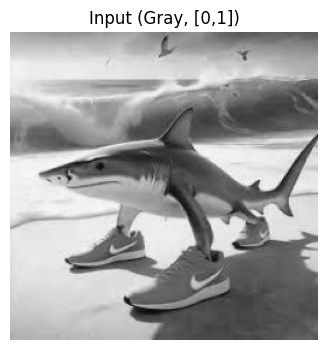

In [4]:
def load_image(path: Optional[str] = None, size: Tuple[int,int]=(256,256)) -> np.ndarray:
    img = Image.open(path).convert('L').resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

# 사용 예시: path=None -> 합성 이미지
img = load_image(path="/content/tralla.jpg", size=(256,256))
show_gray(img, title='Input (Gray, [0,1])')


**Q1. numpy를 사용하여 이미지와 커널 배열을 입력으로 받는 conv2D_naive 함수를 구현하세요**

In [5]:
def conv2d_naive(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    image: (H, W)
    kernel: (kH, kW)

    반환: (outH, outW)
    """
    # padding=0, stride=1 조건으로 구현
    padding = 0
    padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    stride = 1

    ## Todo ##
    H, W = image.shape
    kH, kW = kernel.shape

    # 출력결과 크기 계산 O = (I - K + 2P) / S + 1)
    outH = H - kH + 1
    outW = W - kW + 1

    out = np.zeros((outH, outW))

    for y in range(outH):
        for x in range(outW):
            image_patch = image[y:y + kH, x:x + kW]
            out[y, x] = np.sum(image_patch * kernel)


    ##########
    return out


**Q2. 작성한 코드의 동작 방식이 왜 CNN의 convolution 연산과 동일한지 아래 마크다운에 자세히 설명해주세요. (예시를 들어 설명하셔도 좋습니다)**

1. 커널 이동 (sliding): 이중 for문이 커널(필터)을 이미지 위에서 한 칸씩 이동시킴
2. 패치 추출: image[y:y + KH, x:x + kW]코드가 현재 커널과 겹쳐진 부분의 이미지 조각을 잘라냄
3. 내적 계산 (dot product): np.sum(image_patch*kernel)코드가 잘라낸 이미지 조각과 커널의 element-wise multiplication 후 총 초합을 구해, 해당 위치의 특징 값을 계산함

**라플라시안 필터 적용 및 시각화**


- Laplace Filter  
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}

- Sobel Filter(수직)  
\begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}

- Sobel Filter(수평)
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1
\end{bmatrix}


In [6]:
laplace = np.array([[ 1, 1, 1],
                    [ 1,-8, 1],
                    [ 1, 1, 1]], dtype=np.float32)

sobel_vertical = np.array([[ -1, 0, 1],
                           [ -2, 0, 2],
                           [ -1, 0, 1]], dtype=np.float32)

sobel_horizontal = np.array([[ -1, -2, -1],
                             [  0,  0,  0],
                             [  1,  2,  2]], dtype=np.float32)

print('laplace:\n', laplace)
print('sobel_vertical\n', sobel_vertical)
print('sobel_horizontal:\n', sobel_horizontal)

laplace:
 [[ 1.  1.  1.]
 [ 1. -8.  1.]
 [ 1.  1.  1.]]
sobel_vertical
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
sobel_horizontal:
 [[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  2.]]


**구현한 Conv함수와 주어진 filter로 이미지의 edge를 검출해보세요**
- 결과의 범위가 음수가 될 수 있어, 시각화를 위해 정규화 사용

In [7]:
def apply_filter_and_visualize(img: np.ndarray, kernel: np.ndarray, stride: int = 1):

    resp = conv2d_naive(img, kernel)
    resp_signed = minmax_norm(resp)      # [-?, +?] -> [0,1] 정규화

    show_gray(img, 'Input')
    show_gray(resp_signed, 'Laplacian response (signed → min-max normalized)')
    return resp

=== Laplacian ===


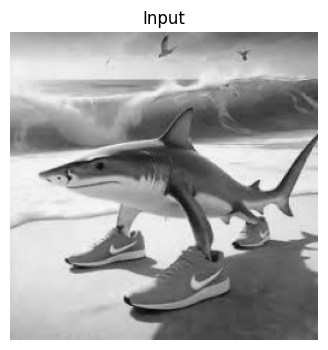

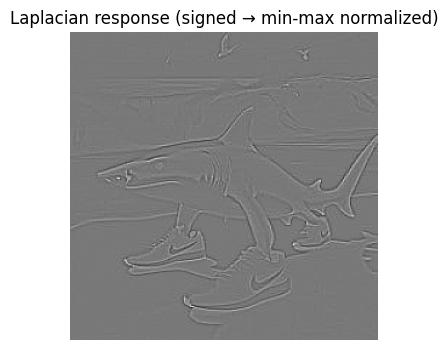

=== Sobel Vertical ===


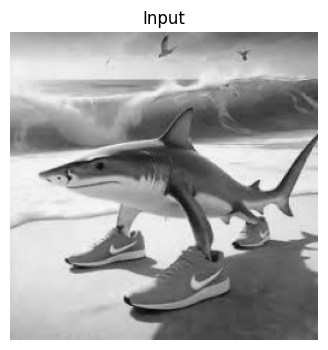

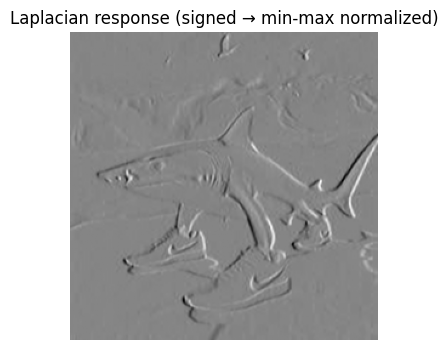

=== Sobel Horizontal ===


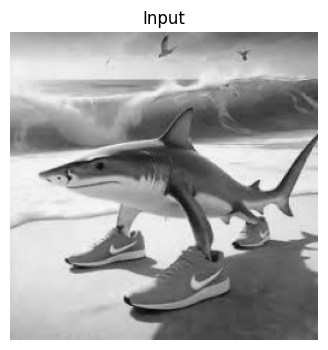

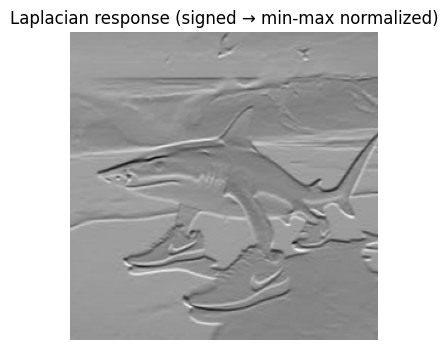

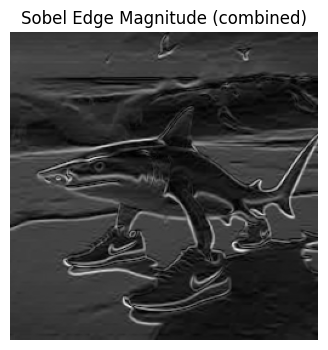

In [8]:
print('=== Laplacian ===')
resp_lp = apply_filter_and_visualize(img, laplace)

print('=== Sobel Vertical ===')
resp_sv = apply_filter_and_visualize(img, sobel_vertical)

print('=== Sobel Horizontal ===')
resp_sh = apply_filter_and_visualize(img, sobel_horizontal)

edge_mag = np.sqrt(resp_sv**2 + resp_sh**2)
edge_mag = minmax_norm(edge_mag)

show_gray(edge_mag, 'Sobel Edge Magnitude (combined)')

# Resnet18 구현하기

앞선 문제에서 Convolution 연산을 구현하여 보았으니,  
이번에는 **Resnet18을 직접 구현**해보고자 합니다.  
**Pytorch의 nn.Conv2d를 사용하시면 되지만**,  
본인이 구현한 Conv2d가 backward 연산이 가능하도록 설계되었다면 그것을 사용하여 구현하셔도 좋습니다.

**라이브러리 및 함수 정의**

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

data_path = "./data"

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.8MB/s]


In [10]:
def train(model, trainloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,
        weight_decay=5e-4,
        momentum=0.9
    )
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader,desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(trainloader)}")

def test(model, testloader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

**Q1. CIFAR10 데이터셋을 분류하는 Resnet18 classifier를 구현하세요**

Input (Batch size x 3 x 32 x 32) / Output (Batch size x Num class)  
이미지 배치를 입력받아 label 개수에 맞는 logit을 반환하도록 BasicBlock과 ResNet18 class를 정의해주세요.  
**ImageNet(224x224)을 입력으로 받는 Original ResNet18과 달리 CIFAR10(32x32)을 입력으로 받으므로,**  
- **conv1과 conv2 layer의 filter size와, maxpooling, stride,**  
- **fc layer의 output dimension을 적절히 변형하셔야 합니다.**
- **ResNet의 Architecture는 아래와 같습니다**

![사진](./ResNet_Architectures.png)

In [11]:
class BasicBlock(nn.Module):

    #### Todo ####

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip Connection (Shortcut)을 위한 레이어
        self.shortcut = nn.Sequential()
        # stride가 1이 아니거나 입력과 출력 채널 수가 다를 경우, shortcut 경로에서도 차원을 맞추기 위한 연산 추가
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    import torch.nn.functional as F

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      out = F.relu(self.bn1(self.conv1(x))) # ReLU 추가
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out


    ##############



class ResNet18(nn.Module):


    ###### Todo ######

    def __init__(self, num_classes: int = 10) -> None:
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels: int, num_blocks: int, stride: int) -> nn.Sequential:
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)


        return out

    ##################

모델이 안정적으로 학습되는지, 테스트 정확도가 잘 나오는지 (80% 이상) 확인해보세요

In [12]:
torch.manual_seed(42)
model = ResNet18().to(device)
train(model, trainloader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [00:43<00:00, 11.55it/s]


Epoch 1/20, Loss: 1.2633210923671723


Epoch 2/20: 100%|██████████| 500/500 [00:42<00:00, 11.69it/s]


Epoch 2/20, Loss: 0.7372375192642212


Epoch 3/20: 100%|██████████| 500/500 [00:43<00:00, 11.53it/s]


Epoch 3/20, Loss: 0.5247783594727516


Epoch 4/20: 100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


Epoch 4/20, Loss: 0.38656285479664804


Epoch 5/20: 100%|██████████| 500/500 [00:43<00:00, 11.38it/s]


Epoch 5/20, Loss: 0.27434668776392934


Epoch 6/20: 100%|██████████| 500/500 [00:44<00:00, 11.35it/s]


Epoch 6/20, Loss: 0.19510248184204101


Epoch 7/20: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]


Epoch 7/20, Loss: 0.13910423868522048


Epoch 8/20: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s]


Epoch 8/20, Loss: 0.09696485178545117


Epoch 9/20: 100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


Epoch 9/20, Loss: 0.07501134091243147


Epoch 10/20: 100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


Epoch 10/20, Loss: 0.06129319868609309


Epoch 11/20: 100%|██████████| 500/500 [00:44<00:00, 11.24it/s]


Epoch 11/20, Loss: 0.03992159531824291


Epoch 12/20: 100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


Epoch 12/20, Loss: 0.041774827567394826


Epoch 13/20: 100%|██████████| 500/500 [00:45<00:00, 11.10it/s]


Epoch 13/20, Loss: 0.030821461362298578


Epoch 14/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 14/20, Loss: 0.028019136029761284


Epoch 15/20: 100%|██████████| 500/500 [00:45<00:00, 11.11it/s]


Epoch 15/20, Loss: 0.01638445165287703


Epoch 16/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 16/20, Loss: 0.006695520615205169


Epoch 17/20: 100%|██████████| 500/500 [00:44<00:00, 11.14it/s]


Epoch 17/20, Loss: 0.0021285055116168224


Epoch 18/20: 100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


Epoch 18/20, Loss: 0.0010751546788669657


Epoch 19/20: 100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


Epoch 19/20, Loss: 0.0007879372829047497


Epoch 20/20: 100%|██████████| 500/500 [00:44<00:00, 11.22it/s]

Epoch 20/20, Loss: 0.0007156074540107511


In [13]:
test(model, testloader, device)

Test Accuracy: 85.92%


85.92

**Q2. Original ResNet18과 CIFAR10 분류용으로 구현한 ResNet18의 차이점과 그렇게 수정한 이유를 아래 마크다운에 자세히 설명해주세요.**

Original ResNet18 모델은 224x224 픽셀의 고해상도 ImageNet 데이터셋에 맞춰 설계되었지만, CIFAR10 데이터셋의 이미지는 32x32 픽셀로 훨씬 작습니다. 이러한 크기 차이를 고려하지 않고 원본 모델을 그대로 사용하면 정보 손실이 커져 성능이 저하될 수 있으므로, CIFAR10용 모델은 초기 레이어 구조를 수정하여 작은 이미지의 공간 정보를 효과적으로 보존하도록 변경되었습니다.

가장 핵심적인 수정은 모델의 초반부에서 이루어졌습니다. Original ResNet18은 kernel_size=7, stride=2인 conv1 레이어와 그 뒤를 잇는 MaxPool 레이어를 통해 입력 이미지의 크기를 1/4로 공격적으로 축소합니다. 이는 연산량을 줄이고 넓은 영역의 특징을 빠르게 포착하기 위한 전략이지만, 32x32 크기의 이미지에 적용하면 유의미한 특징들이 소실될 위험이 큽니다.

이를 해결하기 위해 CIFAR10용 모델에서는 conv1 레이어의 kernel_size를 3으로, stride를 1로 줄이고, 초기 MaxPool 레이어를 완전히 제거했습니다. 이로써 모델은 초기 단계에서 이미지의 해상도를 유지하며 세밀한 특징을 학습할 수 있게 되고, 필요한 다운샘플링은 이후의 레이어에서 점진적으로 수행하게 됩니다.

또한, 분류 문제의 최종 목표에 맞게 fc layer의 출력 차원을 ImageNet의 1000개 클래스에서 CIFAR10의 10개 클래스로 변경하여, 모델이 주어진 과제에 맞는 올바른 예측을 출력하도록 수정했습니다.